In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from resources.conv_learner import * # important because our ResNet name needs to override theirs
from resources.plots import *
from common import Statistics, dataset_source
from models import ResNet

In [3]:
PATH = "../datasets/yeast_v5"
data_path = Path(PATH)

In [ ]:
CLASSES = ('WT', 'mfb1KO', 'mfb1KO_mmr1KO', 'mmr1KO', 'mmm1KO_230', 'num1_110')
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 100
SIZE = 200
SEED = 5

# set the seeds for experimentation
np.random.seed(SEED)
torch.cuda.manual_seed_all(SEED)

# check if GPU is available
torch.cuda.is_available()

In [5]:
test_dirs, train_dirs = dataset_source(data_path)
stats_dict = Statistics.per_class(test_dirs, train_dirs)

working on: mfb1KO
working on: mfb1KO_mmr1KO
working on: mmr1KO
working on: WT
working on: mmm1KO_230
working on: num1_110


In [6]:
def get_data(path: str, sz, bs, stats):
    create, lbl2index = ImageClassifierData.prepare_from_path(path, val_name='test', bs=bs)
    stats_dict = {lbl2index[key]: val for key, val in stats.items()}
    tfms = tfms_from_stats(stats_dict, sz, aug_tfms=[RandomDihedral()], pad=sz//8) #even without transformations and padding -> failure
    print('\n class to index mapping:\n',lbl2index)
    return create(tfms)

### the eventual sub-function of ImageClassifierData (read_dirs) expects subdirectories for each class: 
### e.g. all "test/cat.png" images should be in a "cat" folder. 

In [7]:
data = get_data(PATH,SIZE, BATCH_SIZE,stats_dict)


 class to index mapping:
 {'WT': 0, 'mfb1KO': 1, 'mfb1KO_mmr1KO': 2, 'mmm1KO_230': 3, 'mmr1KO': 4, 'num1_110': 5}


In [8]:
x, y = next(iter(data.trn_dl))

In [9]:
print(y.size())

torch.Size([100])


/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


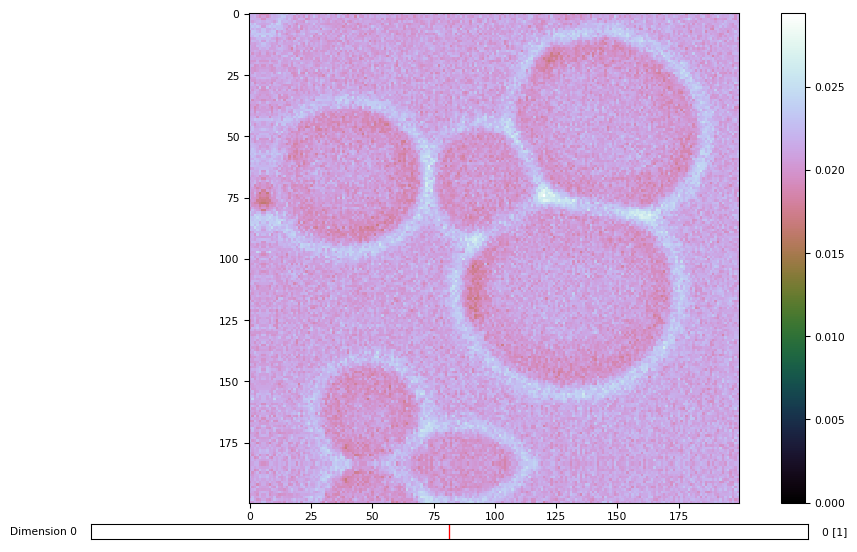

In [10]:
idx = 30
tiff.imshow(data.trn_ds.denorm(x[idx], y[idx]).squeeze()[:,:,0]); #denorm function called has a rollaxis() hence indexing changes.

# Training setup

## ResNet with Batchnorm
Each run of the experiment we start with loading a set of pretrained weights from a saved model. This way we have benchmark from which to judge.

In [11]:
sorted(os.listdir('../datasets/yeast_v5/models'))

['Objective_A_Resnet_per_class_1.h5',
 'Objective_A_Resnet_per_class_balanced_fromstart_1.h5',
 'Objective_A_Resnet_per_class_balanced_fromstart_2.h5',
 'Objective_C_Resnet_per_class_3.h5',
 'Objective_C_Resnet_per_class_balanced_1.h5',
 'Objective_C_Resnet_per_dataset_2.h5',
 'Objective_C_Resnet_per_dataset_3.h5',
 'ResNet5_v5_batch_adj_07-24_16-46.h5',
 'ResNet5_v5_batch_adj_07-24_18-32.h5',
 'ResNet5_v5_batch_adj_07-24_18-55.h5',
 'ResNet5_v5_batch_adj_07-24_19-11.h5',
 'ResNet5_v5_batch_adj_07-24_19-32.h5',
 'ResNet5_v5_batch_adj_07-24_19-55.h5',
 'ResNet5_v5_batch_adj_07-24_19-59.h5',
 'ResNet5_v5_batch_adj_07-24_20-27.h5']

In [ ]:
model = ResNet([10, 20, 40, 80, 160], NUM_CLASSES, obj_name="C", exp_name='v5_batch_adj')
learn = ConvLearner.from_model_data(model, data)
wd=1e-5

In [ ]:
learn.load('Objective_C_Resnet_per_class_balanced_1')

In [ ]:
%time learn.fit(1e-6, 2, wds=wd, cycle_len=1, use_clr=(20,8, 0.95, 0.85), best_save_name=learn.model.tag)

In [ ]:
adjust = {
    5: 90
}
%time learn.fit(1e-3, 8, wds=wd, cycle_len=1, use_clr=(20,8, 0.95, 0.85), adjust_class=adjust, best_save_name=learn.model.tag)

In [ ]:
adjust = {
    0: 25,
    1: 25,
}
%time learn.fit(1e-3, 8, wds=wd, cycle_len=10, use_clr=(20,8, 0.95, 0.85), adjust_class=adjust, best_save_name=learn.model.tag)

In [ ]:
log_preds

In [ ]:
# analyze results 
log_preds, y = learn.TTA(n_aug=1)
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
# cm = confusion_matrix(preds,y)
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)